##Reading from directories

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!ls "/content/drive/My Drive/"

'Colab Notebooks'   digits  'Machine vision-Paper'   names   tumor_classification_other


In [11]:
image_directory  = "/content/drive/My Drive/tumor_classification_other"

In [12]:
classes = !ls "/content/drive/My Drive/tumor_classification_other"
print(classes[0])

glioma	meningioma  pituitary


In [13]:
#create classes ------
classes = classes[0].split()
print(classes)

['glioma', 'meningioma', 'pituitary']


In [14]:
glioma = !ls "/content/drive/My Drive/tumor_classification_other/glioma"
meningioma = !ls "/content/drive/My Drive/tumor_classification_other/meningioma"
pituitary = !ls "/content/drive/My Drive/tumor_classification_other/pituitary"

In [15]:
print(glioma)

['glioma_0.jpg\t glioma_119.jpg   glioma_209.jpg  glioma_408.jpg  glioma_607.jpg  glioma_806.jpg', 'glioma_1000.jpg  glioma_11.jpg\t  glioma_20.jpg   glioma_409.jpg  glioma_608.jpg  glioma_807.jpg', 'glioma_1001.jpg  glioma_1200.jpg  glioma_210.jpg  glioma_40.jpg   glioma_609.jpg  glioma_808.jpg', 'glioma_1002.jpg  glioma_1201.jpg  glioma_211.jpg  glioma_410.jpg  glioma_60.jpg   glioma_809.jpg', 'glioma_1003.jpg  glioma_1202.jpg  glioma_212.jpg  glioma_411.jpg  glioma_610.jpg  glioma_80.jpg', 'glioma_1004.jpg  glioma_1203.jpg  glioma_213.jpg  glioma_412.jpg  glioma_611.jpg  glioma_810.jpg', 'glioma_1005.jpg  glioma_1204.jpg  glioma_214.jpg  glioma_413.jpg  glioma_612.jpg  glioma_811.jpg', 'glioma_1006.jpg  glioma_1205.jpg  glioma_215.jpg  glioma_414.jpg  glioma_613.jpg  glioma_812.jpg', 'glioma_1007.jpg  glioma_1206.jpg  glioma_216.jpg  glioma_415.jpg  glioma_614.jpg  glioma_813.jpg', 'glioma_1008.jpg  glioma_1207.jpg  glioma_217.jpg  glioma_416.jpg  glioma_615.jpg  glioma_814.jpg', 'g

In [16]:
contents = []
directory_contents = {}
#glioma
for content in glioma:
  c = content.split()
  contents.extend(c)
directory_contents['glioma'] = contents
contents = []

#meningioma
for content in meningioma:
  c = content.split()
  contents.extend(c)
directory_contents['meningioma'] = contents
contents = []

#glioma
for content in pituitary:
  c = content.split()
  contents.extend(c)
directory_contents['pituitary'] = contents
contents = []

In [17]:
print(len(directory_contents['pituitary']))
print(len(directory_contents['glioma']))
print(len(directory_contents['meningioma']))

1457
1321
1339


##Data visualization and preprocessing

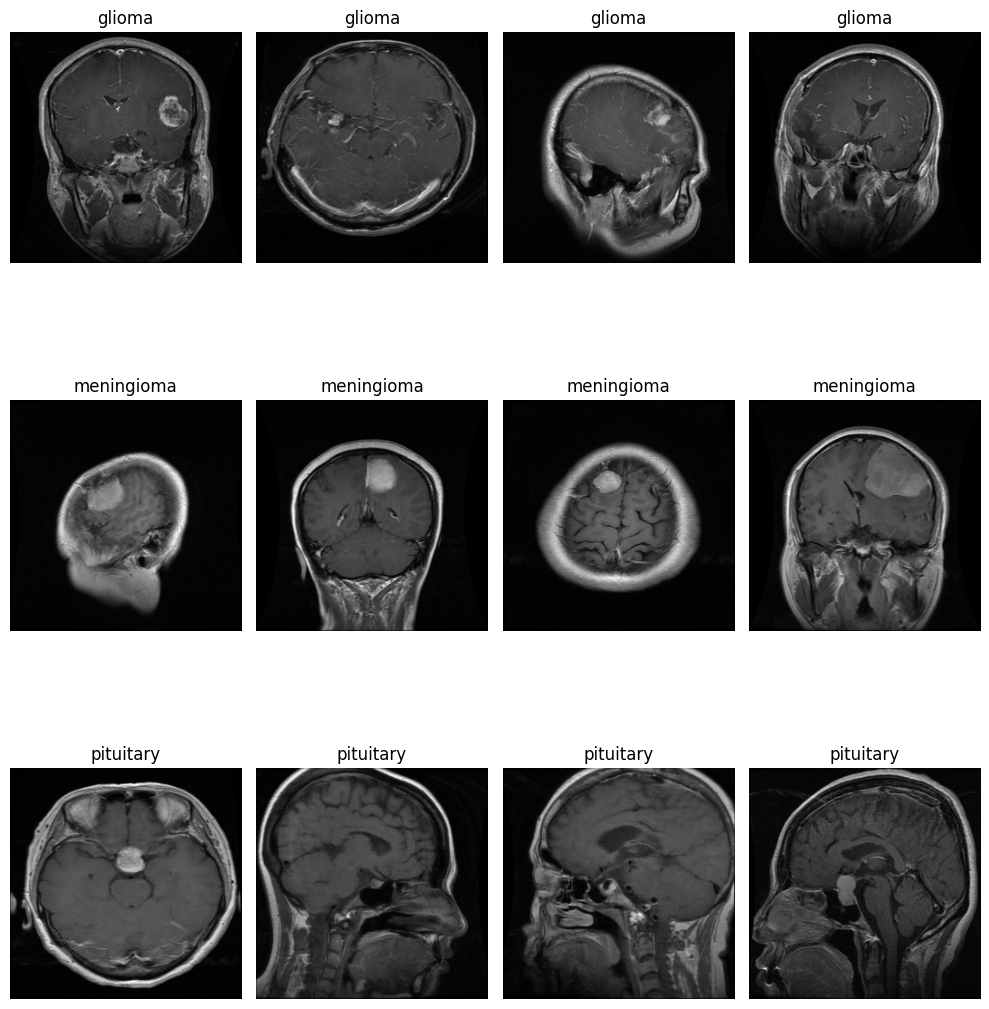

In [18]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axs = plt.subplots(3, 4, figsize=(10, 12))
for c in classes:
  random.shuffle(directory_contents[c])
  photos = directory_contents[c][:4]
  for i in range (4):
    path =  image_directory + "/" + c + "/" + photos[i]
    image = mpimg.imread(path)
    if c == "glioma":
      axs[0,i].imshow(image, cmap='gray')
      axs[0,i].axis('off')
      axs[0,i].set_title(c)
    if c == "meningioma":
      axs[1,i].imshow(image, cmap='gray')
      axs[1,i].axis('off')
      axs[1,i].set_title(c)
    if c == "pituitary":
      axs[2,i].imshow(image, cmap='gray')
      axs[2,i].axis('off')
      axs[2,i].set_title(c)
plt.tight_layout()
plt.show()


In [19]:
import cv2
import numpy as np
def crop_brain_region(image_path):
    # Read the MRI image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Adaptive thresholding to segment the brain region
    thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)

    # Perform morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel, iterations=5)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=5)

    # Find contours of the brain region
    contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 10000]

    if valid_contours:
        # Get the bounding box of the largest contour
        x, y, w, h = cv2.boundingRect(valid_contours[0])

        # Crop the image using the bounding box coordinates
        cropped_image = image[y:y+h, x:x+w]
    else:
        cropped_image = None

    return cropped_image


In [20]:
def apply_clahe(image_path):
    # Read the MRI image
    image = cv2.imread(image_path)

    if len(image.shape) == 2:  # Grayscale image
        clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
        enhanced_image = clahe.apply(image)
    else:  # Color image
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)  # Convert to LAB color space
        l, a, b = cv2.split(lab)  # Split into L, A, B channels
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l_clahe = clahe.apply(l)  # Apply CLAHE to the L channel
        lab_clahe = cv2.merge((l_clahe, a, b))  # Merge the CLAHE-enhanced L channel with A and B
        enhanced_image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)  # Convert back to BGR

    return enhanced_image


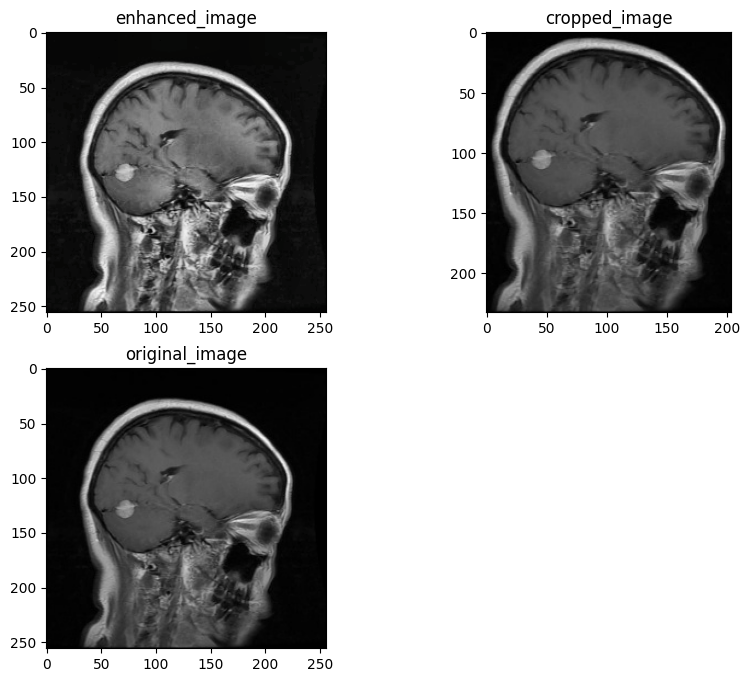

In [21]:
# Check the crop and enhanced methods
random_file = random.choice(directory_contents['meningioma'])
random_file_path = "/content/drive/My Drive/tumor_classification_other/meningioma" + "/" + random_file
cropped_image = crop_brain_region(random_file_path)
enhanced_image = apply_clahe(random_file_path)
original_image = cv2.imread(random_file_path)

# Display the photos
plt.figure(figsize = (10,8))
plt.subplot(2,2,1)
plt.imshow(enhanced_image , cmap = 'gray')
plt.title("enhanced_image")
plt.subplot(2,2,2)
plt.imshow(cropped_image , cmap = 'gray')
plt.title("cropped_image")
plt.subplot(2,2,3)
plt.imshow(original_image , cmap = 'gray')
plt.title("original_image")
plt.show()

##Creating test and train directories and data for the model

In [22]:
import os
import random
output_dir = "/content/drive/MyDrive/tumor_dataset_contrast"
os.makedirs(output_dir, exist_ok=True)

# Create train and test directories
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Process each class
for class_name in classes:

    class_path = os.path.join(image_directory, class_name)
    images = os.listdir(class_path)
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Shuffle and split into train/validation
    random.shuffle(images)
    split_idx = 500
    train_images = images[:500]
    val_images = images[500:700]

    # Process and copy images to the respective directories
    for img in train_images:
        img_path = os.path.join(class_path, img)
        enhanced = apply_clahe(img_path)
        output_path = os.path.join(train_dir, class_name, img)
        cv2.imwrite(output_path, enhanced)

    for img in val_images:
        img_path = os.path.join(class_path, img)
        enhanced = apply_clahe(img_path)
        output_path = os.path.join(test_dir, class_name, img)
        cv2.imwrite(output_path, enhanced)

In [23]:
x = !ls "/content/drive/MyDrive/tumor_dataset_contrast/train/meningioma"
print(len(x))

125


In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

train_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen = ImageDataGenerator(rescale=1.0/255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (64,64),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    shuffle=False,
    target_size = (64,64),
    batch_size=32,
    class_mode='categorical'
)


Found 1500 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


##Building up the deep learning models

In [25]:
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])

model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         401,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 411,811 (1.57 MB)

 Trainable params: 411,811 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])

model3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 29, 29, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,379 (364.76 KB)

 Trainable params: 93,379 (364.76 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model6 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])

model6.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 29, 29, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 841,795 (3.21 MB)

 Trainable params: 841,795 (3.21 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model7 = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])

model6.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 29, 29, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 841,795 (3.21 MB)

 Trainable params: 841,795 (3.21 MB)

 Non-trainable params: 0 (0.00 B)

##Training the model

In [29]:
# Compile the model
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping2 = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint2 = ModelCheckpoint('model2.keras', monitor='val_loss', save_best_only=True, mode="auto", verbose=1)

history2 = model2.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    callbacks=[early_stopping2, model_checkpoint2]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/47 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.4936 - loss: 1.0114
Epoch 1: val_loss improved from inf to 0.71418, saving model to model2.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.5022 - loss: 0.9951 - val_accuracy: 0.7150 - val_loss: 0.7142
Epoch 2/15
40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7358 - loss: 0.6371
Epoch 2: val_loss improved from 0.71418 to 0.47514, saving model to model2.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.7374 - loss: 0.6314 - val_accuracy: 0.8000 - val_loss: 0.4751
Epoch 3/15
40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7989 - loss: 0.4853
Epoch 3: val_loss improved from 0.47514 to 0.43600, saving model to model2.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.8003 - loss: 0.4830 - val_accuracy: 0.8117 - val_loss: 0.4360
Epoch 4/15
40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8239 - loss: 0.4133
Epoch 4: val_loss improved from 0.43600 to 0.42185, saving model to model2.k

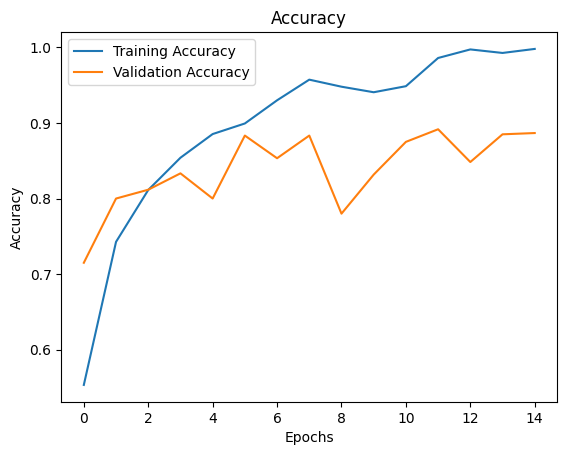

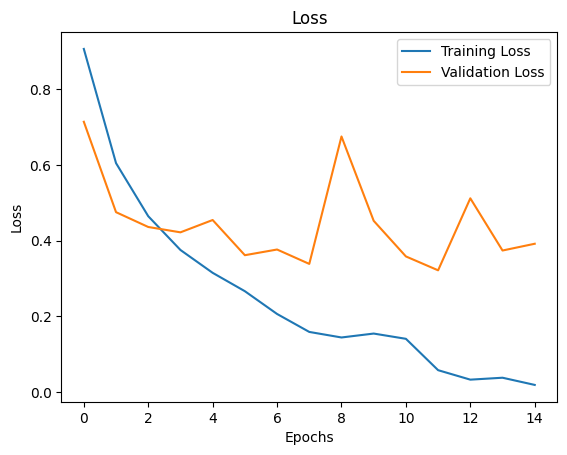

In [30]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step


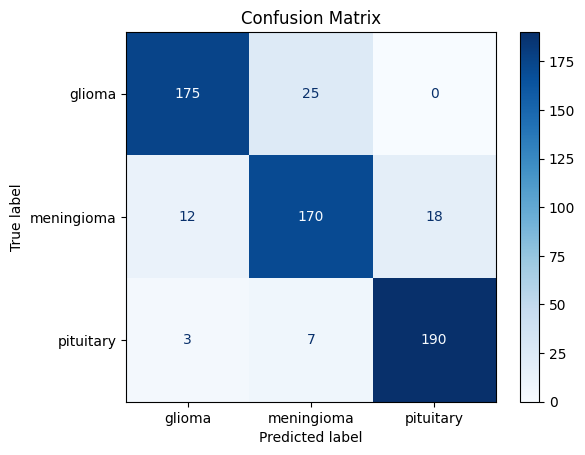

In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

predictions = model2.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes , predicted_classes)

#plot---
disp = ConfusionMatrixDisplay(confusion_matrix = cm , display_labels = class_labels)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [32]:
# Compile the model
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping3 = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint3 = ModelCheckpoint('model3.keras', monitor='val_loss', save_best_only=True, mode="auto", verbose=1)

history3 = model3.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    callbacks=[early_stopping3, model_checkpoint3]
)


Epoch 1/15
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.4563 - loss: 1.0256
Epoch 1: val_loss improved from inf to 0.70359, saving model to model3.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 291ms/step - accuracy: 0.4617 - loss: 1.0188 - val_accuracy: 0.7000 - val_loss: 0.7036
Epoch 2/15
40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6833 - loss: 0.7184
Epoch 2: val_loss did not improve from 0.70359
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.6890 - loss: 0.7113 - val_accuracy: 0.6650 - val_loss: 0.7453
Epoch 3/15
40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7600 - loss: 0.5939
Epoch 3: val_loss improved from 0.70359 to 0.50131, saving model to model3.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.7632 - loss: 0.5857 - val_accuracy: 0.7950 - val_loss: 0.5013
Epoch 4/15
40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8153 - loss: 0.4465
Epoch 4: val_loss did not improve from 0.50131
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy

In [33]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('model3.keras')

# Evaluate on the test set
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.8746 - loss: 0.3636
Test Accuracy: 0.89, Test Loss: 0.33


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step


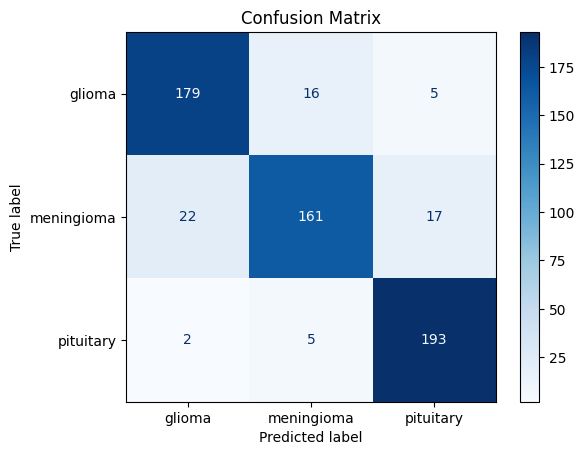

In [34]:
import numpy as np
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

predictions = model3.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes , predicted_classes)

#plot---
disp = ConfusionMatrixDisplay(confusion_matrix = cm , display_labels = class_labels)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

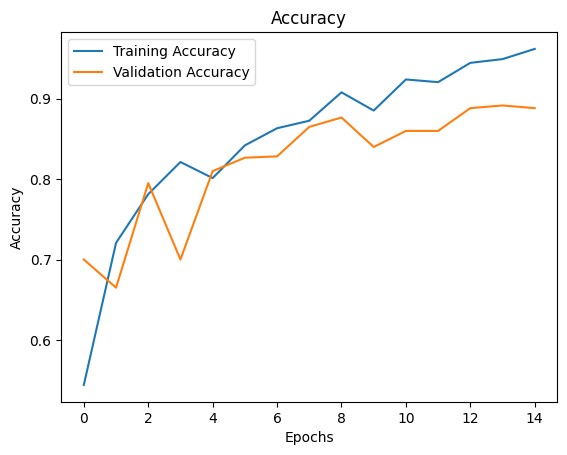

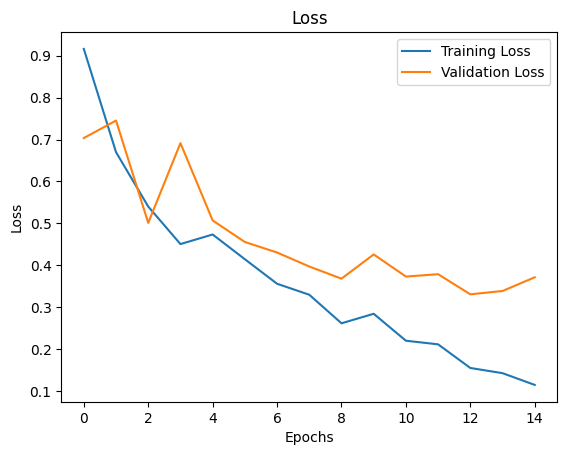

In [35]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
# Compile the model
model6.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping6 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint6 = ModelCheckpoint('model6.keras', monitor='val_loss', save_best_only=True, mode="auto", verbose=1)

history6 = model6.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping6, model_checkpoint6]
)

Epoch 1/10
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5052 - loss: 0.9782
Epoch 1: val_loss improved from inf to 0.64339, saving model to model6.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 218ms/step - accuracy: 0.5091 - loss: 0.9740 - val_accuracy: 0.7400 - val_loss: 0.6434
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7302 - loss: 0.6117
Epoch 2: val_loss improved from 0.64339 to 0.55824, saving model to model6.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 0.7300 - loss: 0.6123 - val_accuracy: 0.7867 - val_loss: 0.5582
Epoch 3/10
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8191 - loss: 0.4657
Epoch 3: val_loss improved from 0.55824 to 0.39481, saving model to model6.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.8188 - loss: 0.4654 - val_accuracy: 0.8600 - val_loss: 0.3948
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8647 - loss: 0.3574 
Epoch 4: val_loss improved from 0.39481 to 0.38858, saving model

In [37]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('model6.keras')

# Evaluate on the test set
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.8555 - loss: 0.3405
Test Accuracy: 0.88, Test Loss: 0.33


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step


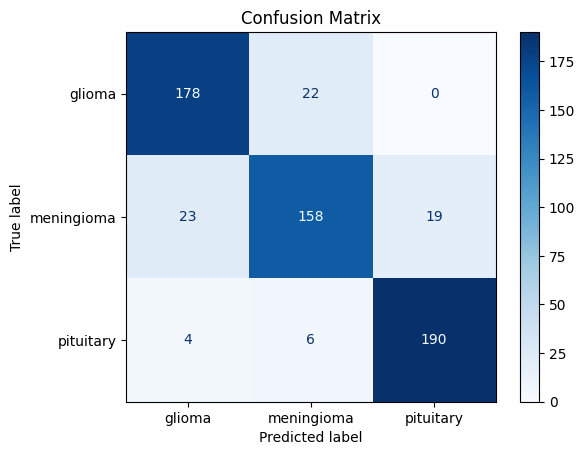

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

predictions = model6.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes , predicted_classes)

#plot---
disp = ConfusionMatrixDisplay(confusion_matrix = cm , display_labels = class_labels)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

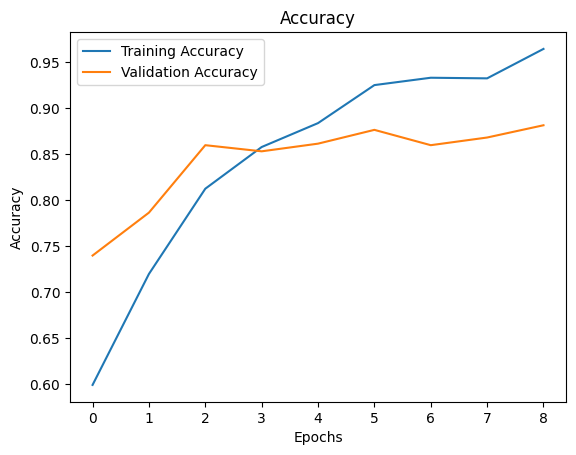

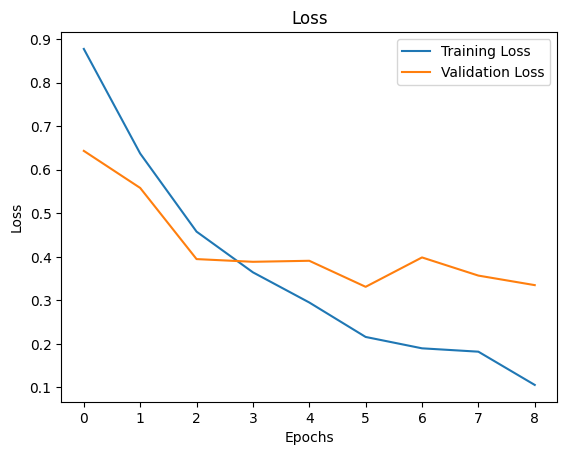

In [39]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history6.history['accuracy'], label='Training Accuracy')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history6.history['loss'], label='Training Loss')
plt.plot(history6.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
# Compile the model
model7.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping7 = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint7 = ModelCheckpoint('model7.keras', monitor='val_loss', save_best_only=True, mode="auto", verbose=1)

history6 = model7.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    callbacks=[early_stopping7, model_checkpoint7]
)

Epoch 1/15
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5029 - loss: 1.0313
Epoch 1: val_loss improved from inf to 0.65131, saving model to model7.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 228ms/step - accuracy: 0.5062 - loss: 1.0259 - val_accuracy: 0.6867 - val_loss: 0.6513
Epoch 2/15
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7018 - loss: 0.6965
Epoch 2: val_loss improved from 0.65131 to 0.59229, saving model to model7.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 185ms/step - accuracy: 0.7019 - loss: 0.6959 - val_accuracy: 0.7517 - val_loss: 0.5923
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8050 - loss: 0.5075 
Epoch 3: val_loss improved from 0.59229 to 0.53916, saving model to model7.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.8052 - loss: 0.5069 - val_accuracy: 0.7900 - val_loss: 0.5392
Epoch 4/15
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8113 - loss: 0.4403
Epoch 4: val_loss improved from 0.53916 to 0.47814, saving model

In [41]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('model7.keras')

# Evaluate on the test set
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.8681 - loss: 0.3359
Test Accuracy: 0.89, Test Loss: 0.31


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step


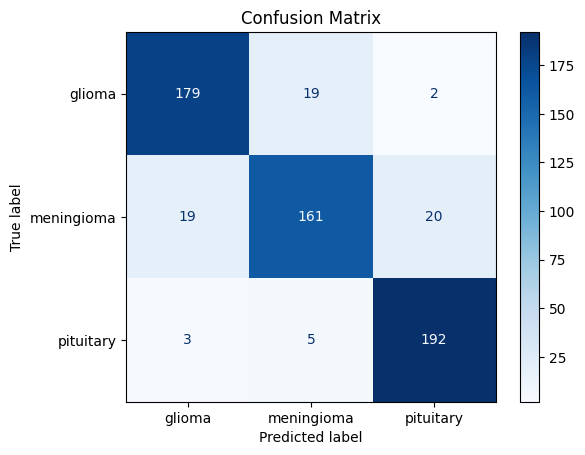

In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

predictions = model7.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes , predicted_classes)

#plot---
disp = ConfusionMatrixDisplay(confusion_matrix = cm , display_labels = class_labels)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

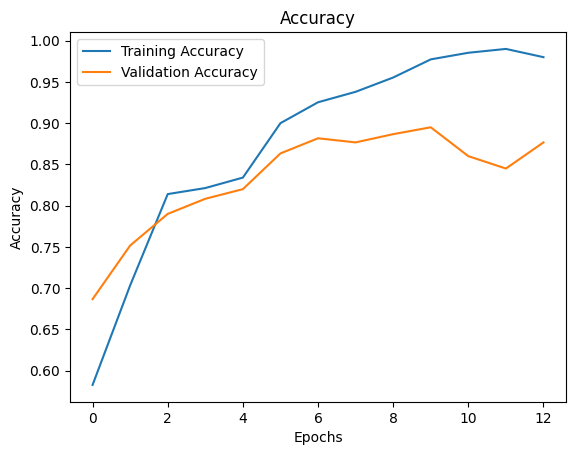

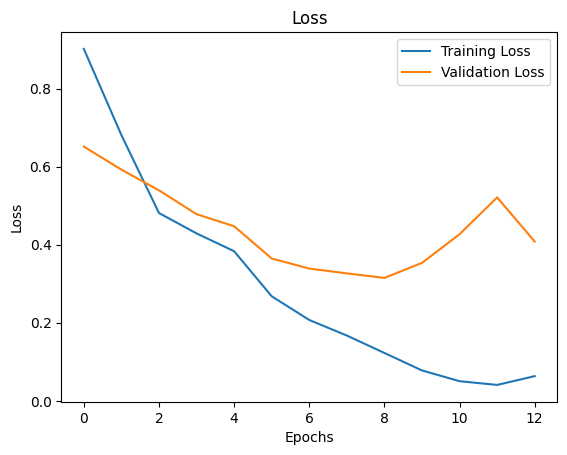

In [43]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history6.history['accuracy'], label='Training Accuracy')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history6.history['loss'], label='Training Loss')
plt.plot(history6.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()